In [33]:
import pandas as pd
import numpy as np

# Functions

In [34]:
def countGenesInGO(df: pd.DataFrame):
    """Count the number of genes in each GO ID

    Args:
        df (pd.DataFrame): bp or mf dataframe
    """
    
    grouped_df = df.groupby('GO ID').agg({'DB_Object_Symbol': list, 'GO ID': 'size'})
    
    grouped_df = grouped_df.rename(columns={'GO ID': 'Group_Size', 'DB_Object_Symbol': 'loGenes'})    
    
    grouped_df = grouped_df.sort_values('Group_Size')
    

    grouped_df = grouped_df.reset_index()

    grouped_df.reset_index(drop=True)
    return grouped_df

In [35]:
def getIntersectingArraysFromOne(testGOTerm: str, loGenesTest: np.array, otherRows: pd.DataFrame):
    
    """
    Get the arrays from a list that have an intersection greater than a given percentage with a test array.
    We are testing the intersection between testArray and the loGenes column of the otherRows dataframe

    Parameters:
        testGOTerm (str): The GO term that you are testing overlap for
        loGenesTest (np.ndarray[str]): List of genes that are afiliated with your testGOTerm
        otherRows: pd.DataFrame: Pandas dataframe where index is GO term, and loGenes is an array of genes contained by that go term

    Returns:
        df_percent_overlap (pd.DataFrame): Df where you have testTerm to other GO term percent overlaps
        
        
    """
    
    # A list of percent overlaps
    lo_percent_overlap = []
    

    for index, row in otherRows.iterrows():
        loGenesArray = row["loGenes"]
        assayGOTerm = row["GO ID"]
        
        ar1, ar2 = IntersectArrays(loGenesTest, loGenesArray) # Gets the percentage of itneractions between all the arrays
        lo_percent_overlap.append([testGOTerm, assayGOTerm, ar1, ar2]) # index will be the array GO Term
        
    
    df_percent_overlap = pd.DataFrame(data = lo_percent_overlap)
    df_percent_overlap.columns = ['test_term', 'other_term', 'perc1', 'perc2']
    
    return df_percent_overlap

def IntersectArrays(array1, array2):
    """
    Check if two numpy arrays have an intersection greater than a given percentage.

    Parameters:
        array1 (numpy.ndarray): The first numpy array.
        array2 (numpy.ndarray): The second numpy array.
        perc (int): The minimum intersection percentage required for the arrays to be considered intersecting.

    Returns:
        intersection_percentage_1, intersection_percentage_2: Two fractions. The first indicates how much % overlap there \
            when array 1 is in the denominator. The second indicates fraction whenarray 2 is in denominator
    """
    intersection = np.intersect1d(array1, array2)
    intersection_percentage_1 = len(intersection) / len(array1)
    intersection_percentage_2 = len(intersection) / len(array2)

    return intersection_percentage_1, intersection_percentage_2


In [36]:
# def removeOverlapForOne(grouped_df: pd.DataFrame, perc: int = 0.8):
#     """Removes GO terms that overlap by X percent of their genes For one GO Term
    

#     Args:
#         df_grouped (pd.DataFrame): mf or bp that is grouped and sorted by ascending value for group size
#         perc (int): Percent overlap that is the cutoff
        
#     Returns:
        
#     """
    
#     for index, row in grouped_df.iterrows():
        
#         # testID is the GO term we are testing overlap FOR
#         testID = row["GO ID"]
#         print('')
#         #print(f'Testing {testID}')
        
#         # testArray will be the genes affiliated with our testID GO Term
#         testArray = row['loGenes'] #
        
#         # otherRows is a dataframe of the other GO terms that are NOT our current test ID GO term
#         otherRows = grouped_df.loc[grouped_df.index != index] # The other arrays
        
#         # There are the intersecting GO Terms
#         intersectingGOs = getIntersectingArraysFromOne(testArray, otherRows, perc)
    
        
#         if len(intersectingGOs) == 0 & index == grouped_df.shape[0]-1: # If we are the end
#             print("At End")
#             return grouped_df
        
#         if len(intersectingGOs) == 0: # If we do not have any intersecting GOs, and we are NOT at the end of our for loop
#             continue # This will continue, But if we are the end of the grouped_df, then we are completely done and we will exit the for loop.
        
#         else: # There was at least one intersectino found. Exit the for loop
#             print(f'There was {len(intersectingGOs)} intersection found for {testID}')
#             break
        
    
#     # Turn intersecting GOs into a dataframe
#     columns = ["GO ID", "pc1" ,"pc2", "loGenes"]
#     dtypes = [str, str, str, list]
#     print(intersectingGOs)
#     intersectingGOs = pd.DataFrame(intersectingGOs, columns = columns).astype(dict(zip(columns, dtypes)))
#     print(intersectingGOs)
#     assert False

#     filtered_grouped_df = grouped_df[~grouped_df['GO ID'].isin(intersectingGOs)]   # Remove the GO ids that we found to intersect
    
#     print(filtered_grouped_df)

#     return removeOverlapForOne(grouped_df=filtered_grouped_df, perc = perc)    

# removeOverlapForOne(mf_grouped, perc = 0.01)
    

In [37]:
def getDependentGOs(df_overlap: pd.DataFrame, overlapPerc: float):
    """ Return a dataframe containing only GO Terms to other GO Terms that overlap

    Args:
        df_merged (pd.DataFrame): _description_
        overlapPerc (float): How much percent you need to overlap
        
    Returns:
        filtered_df (pd.DataFrame): A pandas dataframe containing GO terms that have genes that overlap significantly
    """
    filtered_df = df_overlap[(df_overlap['perc1'] >= overlapPerc) & (df_overlap['perc2'] >= overlapPerc)]
    
    return filtered_df

In [38]:
def createOverlapPercDF(grouped_df: pd.DataFrame):
    """For one grouped df, calculate how many genes in each GO term overlap with the genes in each other GO term
    

    Args:
        df_grouped (pd.DataFrame): mf or bp that is grouped and sorted by ascending value for group size
        
    Returns:
        allPercDCs (pd.DataFrame): All of the GO to other GO term percent overlaps
        
    """
    # A list of percent overlap dataframes
    loPercDFs =[]
    
    for index, row in grouped_df.iterrows():
        
        # testID is the GO term we are testing overlap FOR
        testID = row["GO ID"]

        
        # testArray will be the genes affiliated with our testID GO Term
        testArray = row['loGenes'] #
        
        # otherRows is a dataframe of the other GO terms that are NOT our current test ID GO term
        otherRows = grouped_df.loc[grouped_df.index != index] # The other arrays
        
        # There are the intersecting GO Terms
        percDF = getIntersectingArraysFromOne(testID, testArray, otherRows)
        
        # append to list of perc DFs
        loPercDFs.append(percDF)
        
    # Row bind all of the percent dataframes
    allPercDFs = pd.concat(loPercDFs, axis = 0)
    
    return allPercDFs



In [39]:
def collapseDependentGOTerms(df_grouped: pd.DataFrame, df_dependent:pd.DataFrame):
    """For each row in df_dependent you have a Target Go term and an Other GO term.
    
    For each row of the df_dependent dataframe...
     Find the Target GO term in the df_grouped dataframe.
     Add the Other go term to the df_grouped dataframe
     Then, if you find the Other GO term in the df_dependent as a GO Target...
        Recursively find the target GO term again...
     Exit this section when the Other go term is no longer in df_dependent.

    Args:
        df_grouped (pd.DataFrame): _description_
        df_dependent (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: A Pandas dataframe that has all dependent GO terms collapsed
    """
    
    # Initialize df_grouped to have an empty column of lists
    df_grouped['dependent_go_terms'] = np.empty((len(df_grouped), 0)).tolist()    
    
    
    # For each GO term to target GO term that has been found to be dependent
    for index, row in df_dependent.iterrows():
        
        df_grouped = removeDependentGO(row = row, df_grouped = df_grouped, df_dependent= df_dependent)
    
    return df_grouped
        

def removeDependentGO(dependentRow:pd.Series, df_grouped:pd.DataFrame, df_dependent: pd.DataFrame):
    """
    Find the Target GO term in the df_grouped dataframe.
     Add the Other go term to the df_grouped dataframe
     Then, if you find the Other GO term in the df_dependent as a GO Target...
        Recursively find the target GO term again...
     Exit this section when the Other go term is no longer in df_dependent.

    Args:
        row (pd.Series): _description_
        df_grouped (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    targetGO = dependentRow["test_term"]
    otherGO = dependentRow["other_term"]
    
    # Select the row of our target Term.
    targetRow = df_grouped[df_grouped.loc[:,"GO ID"] == targetGO]
    
    # If index fails to be retreived. Just return the df_grouped because its likely that that GO term was already removed
    if targetRow.empty:
        print(f'{targetGO} WAS NOT FOUND')
        return df_grouped
    
    # Select index of our target term
    targetIndex = targetRow.index[0]

    #Add our Other Term to the "dependent_go_terms" list
    df_grouped.at[targetIndex, 'dependent_go_terms'].append(otherGO)
    
    if otherGO in df_dependent.loc[:,'test_term']:
        
        
        loOtherGOs = recurseOtherGO(otherGO, 
                                    df_dependent=df_dependent)

    #Remove the "otherGO" term from the grouped DF. This will only happen if the otherGO term is NOT a target in df_dependent
    # df_grouped = df_grouped[df_grouped.loc[:,"GO ID"] != otherGO] # I need something other than remove here.
    
    # Reset index
    df_grouped = df_grouped.reset_index(drop=True)
    return df_grouped

# I need a function that just takes a 

def recurseOtherGO(otherGO:str,  df_dependent: pd.DataFrame):
    """We have identified that otherGO is inside df_dependent.
    
    I want to call that row(s) that has otherGO as the test_term.
    
    For each row. I want to

    Args:
        otherGO (str): _description_
        df_dependent (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    
    # See if target GO
    # targetRow is now the df_grouped dependent row filtered
    dependentRow =  df_dependent[df_dependent.loc[:,"test_term"] == targetGO]
    
    # Run function on dependent Row
    df_grouped = removeDependentGO(dependentRow = dependentRow, 
                                    df_grouped = df_grouped,
                                    df_dependent = df_dependent)
    return df_grouped

        
        

In [40]:
def getGOOverlapGroups(df_dependent: pd.DataFrame):
    """Returns a list of all of 

    Args:
        df_dependent (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    
    loOthrs = df_dependent.loc[:,'test_term']

    loGroups = []

    for i in loOthrs:
        group = recurseOtherGOs(df_dependent=df_dependent,
                    otherGO= i,
                    loOtherGOs = np.array([i]))
        
        loGroups.append(group)
    
    return loGroups

In [41]:
def recurseOtherGOs(df_dependent: pd.DataFrame, otherGO:str, loOtherGOs: np.array = np.empty(0)):
    """
    Recursively looks through the GO terms of OtherGO to see if otherGO is within df_dependent.
    If it is then use that term as the target GO, and then call this function on that GO term
    
    Basically, this function returns a list of GO terms affiliated with our otherGO input. The affiliations are determined recursively such that
    we keep going through the otherGO terms of our otherGO input until no otherGO terms have significant overlap.
    
    loOtherGOs (list[str]): a list of GO ids that show significant overlap with our otherGO test term.
    """
    
    
    # First. Get the ROW(s) of in df_dependent that belong to OtherGO
    otherRows = df_dependent[df_dependent.loc[:,'test_term'] == otherGO]

    # If otherRows is empty, then that means that otherGO is NOT a term in the df_dependent list. So all we have to do is return the current loOtherGOs    
    if otherRows.empty:
        return loOtherGOs
    
    # If all of the new values are already seen in loOtherGOs, then we have entered a situation where there is a closed group of GO terms that overlap. In this case just return loOtherGos
    newGOs = np.setdiff1d(otherRows['other_term'].values, loOtherGOs)
    
    # If there are no new GO terms. Then we have reached the end
    if len(newGOs) == 0:
        return loOtherGOs
    
    # Add the otherOtherGOs to the loOtherGOs
    loOtherGOs = np.concatenate([loOtherGOs, newGOs])
    

    for myotherGO in otherRows['other_term'].values:
        loOtherGOs = recurseOtherGOs(df_dependent=df_dependent,
                                    otherGO =  myotherGO,
                                    loOtherGOs = loOtherGOs)
        # If myotherGO is NOT found in the dependent list. Then we want loFoundGOs to be empty, if it not empty then just concat everything we've found up to this point

         
    return loOtherGOs


In [42]:
import random
import itertools


def removeDependents(df_grouped:pd.DataFrame, loGroups_uniq: list):
    """
    Remove the dependent terms from the df_grouped dataframe
    
    Also updates the list of dependent GO terms accordingly
    
    Returns df_gruoped, but without dependent GO Terms
    """
    
    #flat_list = list(filter(None,itertools.chain.from_iterable(my_list)))

    # Initialize df_grouped to have an empty column of lists
    df_grouped['dependent_go_terms'] = np.empty((len(df_grouped), 0)).tolist()

    # Every value in dependent_go_terms is empty

    # Contains all dependent GO Terms
    all_dependent_terms = []

    #For each element in the list
    for group in loGroups_uniq:
        # Randomyl sample one of those GO terms to be the "base GO Term"
        baseGOTerm = np.random.choice(group, 1)[0]

        group = group[group != baseGOTerm] # Group is good. Does not have base GO Term in it
        
        # Call the row of the base GO term in the df_grouped
        baseRow = df_grouped[df_grouped.loc[:,'GO ID'] == baseGOTerm]
        # Select index of our target term
        baseIndex = baseRow.index[0]

        #Add our Other Term to the "dependent_go_terms" list
        dep_go_terms = df_grouped.loc[baseIndex, 'dependent_go_terms']
        dep_go_terms = dep_go_terms + group.tolist()
        
        
        # Now the dependent GO terms have been append to the dep_go_terms 
        df_grouped.at[baseIndex, 'dependent_go_terms'] = dep_go_terms

        
        # Append all the dependent GO terms for our TargetGO term to a list. These will be removed at the end.
        for dependent_term in dep_go_terms:
            all_dependent_terms.append(dependent_term)
            
            
    # Remove each of the non-base terms from the df_grouped. ###### ASSUMES THAT EACH ELEMENT IS UNIQUE. NEED TO TEST FOR THIS BUT IT SHOULD BE TRUE
    for dependent_term in all_dependent_terms:
        df_grouped = df_grouped[df_grouped['GO ID'] != dependent_term]
        print(df_grouped.shape)
        
    return df_grouped
        


Unit Tests

In [12]:
import pandas as pd
import numpy as np
import unittest


class TestCollapseDependentGOTerms(unittest.TestCase):
    
    def setUp(self):
        # Create sample input dataframes
        self.df_grouped = pd.DataFrame({
            'GO ID': [1, 2, 3, 4, 5],
            'dependent_go_terms': [[] for _ in range(5)]
        })
        
        self.df_dependent1 = pd.DataFrame({
            'test_term': [1, 2 ],
            'other_term': [3, 4]
        })
        
        self.df_dependent2 = pd.DataFrame({
            'test_term': [1, 1],
            'other_term': [3, 4]
        })
        
        self.df_dependent3 = pd.DataFrame({ # Two are targeted. But the targeters dont target eachother
            'test_term': [1, 2],
            'other_term': [3, 3]
        })
        
        self.df_dependent4 = pd.DataFrame({ # Two are targeted, and the targeters target eachoter once
            'test_term': [1, 2, 3],
            'other_term': [3, 3, 2]
        })
        
        self.df_dependent5 = pd.DataFrame({ # Two are targeted, and the targeters target eachoter once
            'test_term': [1, 3],
            'other_term': [3, 1]
        })
    
        self.df_dependent6 = pd.DataFrame({ # Two are targeted, and the targeters target eachoter once
            'test_term': [1, 2, 3,4],
            'other_term': [2, 3, 4,1]
        })

    def test_collapseDependentGOTerms1(self):
        
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent1)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 5],
            'dependent_go_terms': [[3], [4], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)

    def test_collapseDependentGOTerms2(self):
        
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent2)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 5],
            'dependent_go_terms': [[3, 4], [], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
        
    def test_collapseDependentGOTerms3(self): # TODO NEed a function do deal with this case
        
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent3)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 4, 5],
            'dependent_go_terms': [[3],[3], [], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
            
    def test_collapseDependentGOTerms4(self): # TODO NEed a function do deal with this case
        
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent4)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 4 , 5],
            'dependent_go_terms': [[3],[3], [], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
    def test_collapseDependentGOTerms5(self):
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent5)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 4, 5],
            'dependent_go_terms': [[3],[], [], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)

        
    def test_collapseDependentGOTerms6(self):
        output = collapseDependentGOTerms(self.df_grouped, self.df_dependent6)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 5],
            'dependent_go_terms': [[2,3,4], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
    def test_removeDependentGO(self):
        target_row = pd.Series({
            'test_term': 2, 
            'other_term': 3
        })
        output = removeDependentGO(target_row, self.df_grouped, df_dependent=self.df_dependent1)
    
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 4, 5],
            'dependent_go_terms': [[], [3], [], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
    def test_removeDependentGOComplex(self):
        target_row = pd.Series({
            'test_term': 2, 
            'other_term': 3
        })
        output = removeDependentGO(target_row, self.df_grouped, df_dependent=self.df_dependent6)
    
        expected_output = pd.DataFrame({
            'GO ID': [2, 5],
            'dependent_go_terms': [[3,4,1], []]
        })
        
        pd.testing.assert_frame_equal(output, expected_output)
        
        
    def test_removeDependentGOMissing(self):
        target_row = pd.Series({
            'test_term': 6, 
            'other_term': 3
        })
        output = removeDependentGO(target_row, self.df_grouped, self.df_dependent1)
        
        expected_output = pd.DataFrame({
            'GO ID': [1, 2, 3, 4, 5],
            'dependent_go_terms': [[], [], [], [],[]]
        })
        pd.testing.assert_frame_equal(output, expected_output)

    # def test_removeDependentGOOneOutput(self):
    #     target_row = pd.Series({
    #         'test_term': 2,
    #         'other_term': 3
    #     })
        
    #     expected_output = pd.DataFrame({
    #         'GO ID': [1, 3, 4, 5],
    #         'dependent_go_terms': [[], [], [], []]
    #     })
        
    #     output = removeDependentGO(target_row, self.df_grouped)
        
    #     pd.testing.assert_frame_equal(output, expected_output)

# Run the tests
unittest.main(argv=[''], exit=False)


EEEEEEFE.
ERROR: test_collapseDependentGOTerms1 (__main__.TestCollapseDependentGOTerms)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_12287/2791273912.py", line 47, in test_collapseDependentGOTerms1
    output = collapseDependentGOTerms(self.df_grouped, self.df_dependent1)
  File "/tmp/ipykernel_12287/778281427.py", line 26, in collapseDependentGOTerms
    df_grouped = removeDependentGO(row = row, df_grouped = df_grouped, df_dependent= df_dependent)
TypeError: removeDependentGO() got an unexpected keyword argument 'row'

ERROR: test_collapseDependentGOTerms2 (__main__.TestCollapseDependentGOTerms)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_12287/2791273912.py", line 58, in test_collapseDependentGOTerms2
    output = collapseDependentGOTerms(self.df_grouped, self.df_dependent2)
  File "/tmp/ipykernel_12287/778281427.py",

6 WAS NOT FOUND


In [13]:
import numpy as np
import pandas as pd
import unittest

# Define a test case class
class TestFunctions(unittest.TestCase):
    

    def test_getIntersectingArraysFromOne(self):
        testGOTerm = 'GO6'
        loGenesTest = np.array(['gene1', 'gene2', 'gene3', 'gene4'])
        otherRows = pd.DataFrame({'GO ID': ['GO1', 'GO2', 'GO3', 'GO4'],
                                  'loGenes': [['gene1', 'gene2', 'gene3', 'gene4'],
                                                ['gene2', 'gene3', 'gene4', 'gene5', 'gene8', 'gene9'],
                                                ['gene2', 'gene3', 'gene4', 'gene5', 'gene8', 'gene9', 'gene10', 'gene11'],

                                                ['gene6', 'gene7', 'gene8', 'gene9']]})

        df_percent_overlap = getIntersectingArraysFromOne(testGOTerm, loGenesTest, otherRows)
        
        print(df_percent_overlap)
        

        expected_result = pd.DataFrame({'test_term': ['GO6', 'GO6', 'GO6', 'GO6'],
                                        'other_term': ['GO1', 'GO2', 'GO3', 'GO4'],
                                        'perc1': [1.0, 0.75, 0.75, 0.0],
                                        'perc2': [1.0, 0.50, 3/8, 0.0]})

        pd.testing.assert_frame_equal(df_percent_overlap, expected_result)

    
    def test_IntersectArrays(self):
        array1 = ['gene1', 'gene2', 'gene3', 'gene4', 'gene5']
        array2 = ['gene3', 'gene4', 'gene5', 'gene6', 'gene7']
        
        result = IntersectArrays(array1, array2)
        
        self.assertEqual(result, (0.6, 0.6))  # Check if the intersection percentages are correct

# Create a test suite
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestFunctions)

# Run the tests and display the results
unittest.TextTestRunner().run(test_suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


  test_term other_term  perc1  perc2
0       GO6        GO1   1.00  1.000
1       GO6        GO2   0.75  0.500
2       GO6        GO3   0.75  0.375
3       GO6        GO4   0.00  0.000


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [14]:
import pandas as pd
import unittest

# Define a test case class
class TestFunctions(unittest.TestCase):

    def test_createOverlapPercDF(self):
        grouped_df = pd.DataFrame({'GO ID': ['GO:0070182', 'GO:0030515', 'GO:0017116', 'GO1'],
                                   'loGenes': [['Gene1', 'Gene2', 'Gene3', 'Gene4'],
                                               ['Gene1', 'Gene2', 'Gene4',],
                                               ['Gene10', 'Gene11', 'Gene12', 'Gene13','Gene14', 'Gene15'],
                                               ['Gene1', 'Gene2', 'Gene3', 'Gene4','Gene13','Gene14', 'Gene15']],
                                   'Group_Size': [4, 3, 6, 7]})

        result = createOverlapPercDF(grouped_df).sort_values(by = ['test_term', 'other_term']).reset_index(drop=True)
        

        # Assert something meaningful about the output or behavior of the function
        # Here, we can check if the resulting DataFrame has the expected shape.
        expected_shape = (12, 4)  # Expected shape of the resulting DataFrame
        self.assertEqual(result.shape, expected_shape)
        
        expected_result = pd.DataFrame({'test_term':['GO:0070182','GO:0070182','GO:0070182',
                                                     'GO:0030515', 'GO:0030515', 'GO:0030515',
                                                     'GO:0017116', 'GO:0017116','GO:0017116', 
                                                     'GO1', 'GO1', 'GO1'],
                                        'other_term':['GO:0030515', 'GO:0017116', 'GO1',
                                                      'GO:0070182', 'GO:0017116', 'GO1',
                                                      'GO:0070182', 'GO:0030515','GO1', 
                                                     'GO:0030515', 'GO:0070182', 'GO:0017116'], 
                                        'perc1':[3/4, 0 , 1,
                                                 1.0, 0, 1,
                                                 0, 0, 0.5,
                                                 3/7, 4/7, 3/7 ],
                                        'perc2':[1.0, 0, 4/7,
                                                 3/4, 0, 3/7,
                                                 0, 0, 3/7, 
                                                 1, 1, 0.5
                                                 ]}).sort_values(by = ['test_term', 'other_term']).reset_index(drop=True)
        pd.testing.assert_frame_equal(expected_result, result)

        # Additionally, you can add assertions to check specific values or columns in the DataFrame.

# Create a test suite
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestFunctions)

# Run the tests and display the results
unittest.TextTestRunner().run(test_suite)



.
----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Main

In [17]:
import seaborn as sns
def main():
    
    
    # mf = pd.read_csv('../data/GO/QC_mfProcessed.csv') # thse are >=20, <=500
    bp = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/qc/bp_annotations_withGeneData_qc_annotations.csv")
    
    ## Group dataframes,  ## Sort dataframes by ascending value

    # mf_grouped = countGenesInGO(mf)
    bp_grouped = countGenesInGO(bp)
    
    ## Create dataframe containing all of the % composition for each go term with each other go term
    # mf_allPercDFs = createOverlapPercDF(mf_grouped)
    bp_allPercDFs = createOverlapPercDF(bp_grouped)

    ## Filter for Cases where the percs are both =>0.5. 
    # mf_dependent = getDependentGOs(mf_allPercDFs, 0.5)
    bp_dependent = getDependentGOs(bp_allPercDFs, 0.5)
    
    ## Condense the list such that for each GO term with significant overlap, collapse them into one.
    # mf_filtered = collapseDependentGOTerms(mf_grouped, mf_dependent)
    bp_filtered = collapseDependentGOTerms(bp_grouped, bp_dependent)

    ## Return a dataframe where the columns are something like, a GO term, a list of GO terms that are depedent. 
    
    return bp_filtered
    
bp_filtered = main()

TypeError: removeDependentGO() got an unexpected keyword argument 'row'

# CURRENT


In [43]:
import pandas as pd
# mf = pd.read_csv('../data/GO/QC_mfProcessed.csv') # thse are >=20, <=500
# bp = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/qc/bp_annotations_withGeneData_qc_annotations.csv")
bp = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")


In [44]:
bp_grouped = countGenesInGO(bp)

In [45]:
def createOverlapPercDF(grouped_df: pd.DataFrame):
    """For one grouped df, calculate how many genes in each GO term overlap with the genes in each other GO term
    

    Args:
        df_grouped (pd.DataFrame): mf or bp that is grouped and sorted by ascending value for group size
        
    Returns:
        allPercDCs (pd.DataFrame): All of the GO to other GO term percent overlaps
        
    """
    # A list of percent overlap dataframes
    loPercDFs =[]
    
    for index, row in grouped_df.iterrows():
        
        # testID is the GO term we are testing overlap FOR
        testID = row["GO ID"]

        
        # testArray will be the genes affiliated with our testID GO Term
        testArray = row['loGenes'] #
        
        # otherRows is a dataframe of the other GO terms that are NOT our current test ID GO term
        otherRows = grouped_df.loc[grouped_df.index != index] # The other arrays
        
        # There are the intersecting GO Terms
        percDF = getIntersectingArraysFromOne(testID, testArray, otherRows)
        
        # append to list of perc DFs
        loPercDFs.append(percDF)
        
    # Row bind all of the percent dataframes
    allPercDFs = pd.concat(loPercDFs, axis = 0)
    
    return allPercDFs



In [46]:
bp_allPercDFs = createOverlapPercDF(bp_grouped)

In [48]:
def getDependentGOs(df_overlap: pd.DataFrame, overlapPerc: float):
    """ Return a dataframe containing only GO Terms to other GO Terms that overlap

    Args:
        df_merged (pd.DataFrame): _description_
        overlapPerc (float): How much percent you need to overlap
        
    Returns:
        filtered_df (pd.DataFrame): A pandas dataframe containing GO terms that have genes that overlap significantly
    """
    filtered_df = df_overlap[(df_overlap['perc1'] >= overlapPerc) & (df_overlap['perc2'] >= overlapPerc)]
    
    return filtered_df

bp_dependent = getDependentGOs(bp_allPercDFs, 0.6)
bp_dependent.shape


(46, 4)

In [56]:
def checkDependentGOs_group3allterms(bp_dependent:pd.DataFrame)->bool:
    """Check our dataframe of dependent GO terms for situations where there is actually 3 or more GO terms that are all dependent with eachother.
    
    If there are any, then raise an error. Currently I have not found this to be the case in my subset of GO terms, so I will not implement a way to deal with this problem because it does not exist

    Args:
        bp_dependent (pd.DataFrame): dataframe of dependent GO terms
    Returns:
        True if we find no sets of go terms of 3 or greater that are dependent

    Raises: ValueError: If we find that there may be a set of GO terms of length 3 or greater that are dependent on eachother
    """

    for test_term in bp_dependent.test_term:
        test_term_calls = bp_dependent[bp_dependent.loc[:,'test_term']==test_term]
        if test_term_calls.shape[0] == 1:
            continue
        else:
            raise ValueError(f'Found a set of GO terms of length 3> that are dependent {test_term_calls}')
    return True

assert checkDependentGOs_group3allterms(bp_dependent=bp_dependent)

In [61]:
# Now that we've made sure that there are only PAIRS of GO terms that are dependent, we can collapse them into eachother.
# shuffle
bp_dependent = bp_dependent.sample(frac=1, random_state=42) 

In [107]:
# Collapse the GO terms that are dependent by randomly selecting one of them
def getGOTermsToRemove(bp_dependent:pd.DataFrame, lo_kept_go_terms:list=[],  lo_removed_go_terms:list=[]) -> list:
    """For a df of GO terms that have been checked to ONLY have GO terms hat are dependent on 1 more GO term,
    
    randomly selects one of those dependent GO terms to keep 

    Args:
        bp_dependent (pd.DataFrame): _description_

    Returns:
        list: _description_
    """
    # shuffle
    bp_dependent = bp_dependent.sample(frac=1, random_state=100)
    
    # iterate through rows, keep target go term. and remove 'other' go term from dataframe
    
    top_row = bp_dependent.iloc[0,:]
    target = top_row['test_term']
    other = top_row['other_term']
    
    # add target to list of kept go terms
    lo_kept_go_terms.append(target)
    lo_removed_go_terms.append(other)
    
    # remove the 'other' call from the df so it is not also kept
    bp_dependent = bp_dependent[bp_dependent['test_term'] != other]
    bp_dependent = bp_dependent[bp_dependent['test_term'] != target]
    
    if bp_dependent.empty:
        return lo_kept_go_terms, lo_removed_go_terms
    else:
        return getGOTermsToRemove(bp_dependent, lo_kept_go_terms, lo_removed_go_terms)

    

lo_kept_go_terms, lo_removed_go_terms = getGOTermsToRemove(bp_dependent=bp_dependent)
lo_kept_go_terms


['GO:0048247',
 'GO:0032212',
 'GO:0070316',
 'GO:0051445',
 'GO:0035521',
 'GO:0042776']

In [88]:
# now that I know what GO terms to keep and remove. I can remove the GOs that I want to remove
def removeDependentGOs(go_annotated:pd.DataFrame, lo_removed_go_terms:list)->pd.DataFrame:
    """Remove dependent GOs

    Args:
        go_annotated (pd.DataFrame): full list of go's with anotations
        lo_removed_go_terms (list): list of GO ids to remove

    Returns:
        pd.DataFrame: independent GOs
    """
    return go_annotated[~go_annotated.isin(lo_removed_go_terms)]

In [95]:
final_go_annotated = removeDependentGOs(go_annotated = bp, lo_removed_go_terms = lo_removed_go_terms)

In [104]:
def getOnlyGOTermsToKeep(final_go_annotated:pd.DataFrame) -> list:
    """Get a list of the GO Ids we want to keep

    Args:
        final_go_annotated (pd.DataFrame): go annotated df

    Returns:
        list: lo Go terms to keep
    """
    lo_go_ids = final_go_annotated.loc[:,"GO ID"].unique()
    return lo_go_ids

lo_go_ids = getOnlyGOTermsToKeep(final_go_annotated=final_go_annotated)
len(lo_go_ids)

1397

In [96]:
final_go_annotated

,DB_Object_Symbol,GO ID,Aspect,DB Object Name,ensembl_gene_id,hgnc_symbol,uniprotswissprot,entrezgene_id,description
0,IRGM,GO:0000045,P,Immunity-related GTPase family M protein,ENSG00000237693,IRGM,A1A4Y4,345611.0,immunity related GTPase M [Source:HGNC Symbol;...
1,BECN2,GO:0000045,P,Beclin-2,ENSG00000196289,BECN2,A8MW95,441925.0,beclin 2 [Source:HGNC Symbol;Acc:HGNC:38606]
2,AP4M1,GO:0000045,P,AP-4 complex subunit mu-1,ENSG00000221838,AP4M1,NaN,9179.0,adaptor related protein complex 4 subunit mu 1...
3,ATG13,GO:0000045,P,Autophagy-related protein 13,ENSG00000175224,ATG13,NaN,9776.0,autophagy related 13 [Source:HGNC Symbol;Acc:H...
4,ULK1,GO:0000045,P,Serine/threonine-protein kinase ULK1,ENSG00000177169,ULK1,O75385,8408.0,unc-51 like autophagy activating kinase 1 [Sou...
...,...,...,...,...,...,...,...,...,...
76885,BOK,GO:2001244,P,Bcl-2-related ovarian killer protein,ENSG00000176720,BOK,Q9UMX3,666.0,BCL2 family apoptosis regulator BOK [Source:HG...
76886,PLAGL2,GO:2001244,P,Zinc finger protein PLAGL2,ENSG00000126003,PLAGL2,Q9UPG8,5326.0,PLAG1 like zinc finger 2 [Source:HGNC Symbol;A...
76887,FIS1,GO:2001244,P,Mitochondrial fission 1 protein,ENSG00000214253,FIS1,NaN,51024.0,"fission, mitochondrial 1 [Source:HGNC Symbol;A..."
76888,RIPK3,GO:2001244,P,Receptor-interacting serine/threonine-protein ...,ENSG00000285379,RIPK3,Q9Y572,11035.0,receptor interacting serine/threonine kinase 3...


In [68]:
len(lo_kept_go_terms)

12

In [69]:
bp_dependent.shape

(12, 4)

In [64]:
bp_dependent.head()

,test_term,other_term,perc1,perc2
1111,GO:0042776,GO:0009060,0.746032,0.712121
685,GO:0051973,GO:0032212,0.705882,0.705882
201,GO:0051445,GO:0031145,0.800000,0.727273
687,GO:0032212,GO:0051973,0.705882,0.705882
349,GO:2000819,GO:0070316,0.888889,0.960000


In [ ]:
def collapseDependentGOTerms(df_grouped: pd.DataFrame, df_dependent:pd.DataFrame):
    """For each row in df_dependent you have a Target Go term and an Other GO term.
    
    For each row of the df_dependent dataframe...
     Find the Target GO term in the df_grouped dataframe.
     Add the Other go term to the df_grouped dataframe
     Then, if you find the Other GO term in the df_dependent as a GO Target...
        Recursively find the target GO term again...
     Exit this section when the Other go term is no longer in df_dependent.

    Args:
        df_grouped (pd.DataFrame): _description_
        df_dependent (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: A Pandas dataframe that has all dependent GO terms collapsed
    """
    
    # Initialize df_grouped to have an empty column of lists
    df_grouped['dependent_go_terms'] = np.empty((len(df_grouped), 0)).tolist()    
    
    
    # For each GO term to target GO term that has been found to be dependent
    for index, row in df_dependent.iterrows():
        
        df_grouped = removeDependentGO(row = row, df_grouped = df_grouped, df_dependent= df_dependent)
    
    return df_grouped
        

def removeDependentGO(dependentRow:pd.Series, df_grouped:pd.DataFrame, df_dependent: pd.DataFrame):
    """
    Find the Target GO term in the df_grouped dataframe.
     Add the Other go term to the df_grouped dataframe
     Then, if you find the Other GO term in the df_dependent as a GO Target...
        Recursively find the target GO term again...
     Exit this section when the Other go term is no longer in df_dependent.

    Args:
        row (pd.Series): _description_
        df_grouped (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    targetGO = dependentRow["test_term"]
    otherGO = dependentRow["other_term"]
    
    # Select the row of our target Term.
    targetRow = df_grouped[df_grouped.loc[:,"GO ID"] == targetGO]
    
    # If index fails to be retreived. Just return the df_grouped because its likely that that GO term was already removed
    if targetRow.empty:
        print(f'{targetGO} WAS NOT FOUND')
        return df_grouped
    
    # Select index of our target term
    targetIndex = targetRow.index[0]

    #Add our Other Term to the "dependent_go_terms" list
    df_grouped.at[targetIndex, 'dependent_go_terms'].append(otherGO)
    
    if otherGO in df_dependent.loc[:,'test_term']:
        
        
        loOtherGOs = recurseOtherGO(otherGO, 
                                    df_dependent=df_dependent)

    #Remove the "otherGO" term from the grouped DF. This will only happen if the otherGO term is NOT a target in df_dependent
    # df_grouped = df_grouped[df_grouped.loc[:,"GO ID"] != otherGO] # I need something other than remove here.
    
    # Reset index
    df_grouped = df_grouped.reset_index(drop=True)
    return df_grouped

# I need a function that just takes a 

def recurseOtherGO(otherGO:str,  df_dependent: pd.DataFrame):
    """We have identified that otherGO is inside df_dependent.
    
    I want to call that row(s) that has otherGO as the test_term.
    
    For each row. I want to

    Args:
        otherGO (str): _description_
        df_dependent (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    
    # See if target GO
    # targetRow is now the df_grouped dependent row filtered
    dependentRow =  df_dependent[df_dependent.loc[:,"test_term"] == targetGO]
    
    # Run function on dependent Row
    df_grouped = removeDependentGO(dependentRow = dependentRow, 
                                    df_grouped = df_grouped,
                                    df_dependent = df_dependent)
    return df_grouped

        
        

In [ ]:
bp_filtered = collapseDependentGOTerms(bp_grouped, bp_dependent)

# Main Run

In [14]:
# mf = pd.read_csv('../data/GO/QC_mfProcessed.csv') # thse are >=20, <=500

# import sys
# # Define the file path for the log file
# #log_file_path = "/home/aadrian/Masters/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/bin/overlaplog.txt"

# # Redirect standard output to the log file
# #sys.stdout = open(log_file_path, "w")

# # Your code here
# print("This will be written to the log file.")


# mf_grouped = countGenesInGO(mf)
# # bp_grouped = countGenesInGO(bp)

# mf_allPercDFs = createOverlapPercDF(mf_grouped)

# mf_dependent = getDependentGOs(mf_allPercDFs, 0.5)

# # List of all Groups of dependent GO terms
# loGroups = getGOOverlapGroups(df_dependent=mf_dependent)

# # Filter

# mf_filtered = collapseDependentGOTerms(mf_grouped, mf_dependent)


# # Reset standard output to the console
# #sys.stdout = sys.__stdout__

# #GO:0004177 is one example like the unit test 4 ( think) Where

KeyError: 'GO ID'

{"IntersectArrays": "function", "TestCollapseDependentGOTerms": "type", "TestFunctions": "type", "collapseDependentGOTerms": "function", "countGenesInGO": "function", "createOverlapPercDF": "function", "getDependentGOs": "function", "getIntersectingArraysFromOne": "function", "loOtherGOs": "ndarray", "log_file_path": "str", "mf": "DataFrame", "mf_allPercDFs": "DataFrame", "mf_dependent": "DataFrame", "mf_grouped": "DataFrame", "np": "module", "otherGO_t": "str", "otherRows": "DataFrame", "pd": "module", "recurseOTherGOs": "function", "recurseOtherGOs": "function", "removeDependentGO": "function", "sys": "module", "test_suite": "TestSuite", "unittest": "module"}
{"IntersectArrays": "function", "TestCollapseDependentGOTerms": "type", "TestFunctions": "type", "collapseDependentGOTerms": "function", "countGenesInGO": "function", "createOverlapPercDF": "function", "getDependentGOs": "function", "getIntersectingArraysFromOne": "function", "loOtherGOs": "ndarray", "log_file_path": "str", "mf"

TEST

In [132]:
def run_main(GO_path:str, filtered_path:str):
    GO_df = pd.read_csv(GO_path) # thse are >=20, <=500
    
    df_grouped = countGenesInGO(GO_df)
    
    df_allPercDFs = createOverlapPercDF(df_grouped)
    
    df_dependent = getDependentGOs(df_allPercDFs, 0.5)
    
    loGroups = getGOOverlapGroups(df_dependent)

    unique_lists_set = set()
    loGroups_uniq = [x for x in loGroups if tuple(x) not in unique_lists_set and not unique_lists_set.add(tuple(x))]
    
    df_grouped_filtered = removeDependents(df_grouped, loGroups_uniq)
    
    df_grouped_filtered.to_csv(filtered_path, index = False)
    
    

run_main('../data/GO/QC_mfProcessed.csv', '../data/GO/QC_mf_nonDependent.csv')

(405, 4)
(404, 4)
(403, 4)
(402, 4)
(401, 4)
(400, 4)
(399, 4)
(398, 4)
(397, 4)
(396, 4)
(395, 4)
(394, 4)
(394, 4)
(393, 4)
(392, 4)
(391, 4)
(390, 4)
(389, 4)
(389, 4)
(389, 4)
(389, 4)
(388, 4)
(388, 4)
(387, 4)
(386, 4)
(385, 4)
(384, 4)
(383, 4)
(382, 4)
(381, 4)
(380, 4)
(379, 4)
(379, 4)
(379, 4)
(379, 4)
(379, 4)
(378, 4)
(378, 4)
(377, 4)
(376, 4)
(375, 4)
(374, 4)
(373, 4)
(372, 4)
(371, 4)
(371, 4)
(371, 4)
(371, 4)
(371, 4)
(371, 4)
(371, 4)
(371, 4)
(370, 4)
(369, 4)
(368, 4)
(368, 4)
(367, 4)
(366, 4)
(366, 4)
(366, 4)
(366, 4)
(366, 4)
(366, 4)
(365, 4)
(365, 4)
(364, 4)
(363, 4)
(363, 4)
(363, 4)
(363, 4)
(362, 4)
(361, 4)
(360, 4)
(359, 4)
(358, 4)
(357, 4)
(357, 4)
(357, 4)
(356, 4)
(355, 4)
(355, 4)
(355, 4)
(355, 4)
(354, 4)
(353, 4)
(353, 4)
(353, 4)
(353, 4)
(352, 4)
(351, 4)
(351, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(349, 4)
(349, 4)
(349, 4)
(348, 4)
(347, 4)
(346, 4)
(345, 4)
(344, 4)
(343, 4)
(343, 4)
(343, 4)
(342, 4)
(

In [133]:
run_main('../data/GO/QC_bpProcessed.csv', '../data/GO/QC_bp_nonDependent.csv')

(1409, 4)
(1408, 4)
(1407, 4)
(1406, 4)
(1405, 4)
(1404, 4)
(1403, 4)
(1402, 4)
(1401, 4)
(1400, 4)
(1399, 4)
(1398, 4)
(1397, 4)
(1396, 4)
(1395, 4)
(1394, 4)
(1393, 4)
(1393, 4)
(1392, 4)
(1391, 4)
(1390, 4)
(1389, 4)
(1388, 4)
(1387, 4)
(1386, 4)
(1385, 4)
(1384, 4)
(1383, 4)
(1383, 4)
(1382, 4)
(1381, 4)
(1380, 4)
(1379, 4)
(1378, 4)
(1377, 4)
(1376, 4)
(1375, 4)
(1374, 4)
(1373, 4)
(1372, 4)
(1371, 4)
(1370, 4)
(1369, 4)
(1368, 4)
(1367, 4)
(1366, 4)
(1365, 4)
(1364, 4)
(1363, 4)
(1362, 4)
(1361, 4)
(1360, 4)
(1359, 4)
(1358, 4)
(1357, 4)
(1356, 4)
(1355, 4)
(1354, 4)
(1353, 4)
(1352, 4)
(1351, 4)
(1350, 4)
(1349, 4)
(1348, 4)
(1347, 4)
(1346, 4)
(1345, 4)
(1345, 4)
(1345, 4)
(1344, 4)
(1344, 4)
(1343, 4)
(1342, 4)
(1341, 4)
(1340, 4)
(1339, 4)
(1338, 4)
(1337, 4)
(1336, 4)
(1335, 4)
(1334, 4)
(1333, 4)
(1332, 4)
(1331, 4)
(1330, 4)
(1329, 4)
(1328, 4)
(1327, 4)
(1326, 4)
(1325, 4)
(1324, 4)
(1323, 4)
(1322, 4)
(1322, 4)
(1321, 4)
(1320, 4)
(1319, 4)
(1318, 4)
(1317, 4)
(1316, 4)


In [18]:
def removeOverlapMFandBP(mf_path:str, bp_path:str, filtered_path:str):
    
    mf_df = pd.read_csv(mf_path) # thse are >=20, <=500
    bp_df = pd.read_csv(bp_path)
    
    merged_df = pd.concat([mf_df, bp_df], axis = 0)
    
    df_grouped = countGenesInGO(merged_df)
    
    df_allPercDFs = createOverlapPercDF(df_grouped)
    
    df_dependent = getDependentGOs(df_allPercDFs, 0.5)
    
    loGroups = getGOOverlapGroups(df_dependent)

    unique_lists_set = set()
    loGroups_uniq = [x for x in loGroups if tuple(x) not in unique_lists_set and not unique_lists_set.add(tuple(x))]
    
    df_grouped_filtered = removeDependents(df_grouped, loGroups_uniq)
    
    df_grouped_filtered.to_csv(filtered_path, index = False)


removeOverlapMFandBP ('../data/GO/QC_mfProcessed.csv', '../data/GO/QC_bpProcessed.csv', '../data/GO/QC_mfbp_independent.csv' )

(1815, 4)
(1814, 4)
(1813, 4)
(1812, 4)
(1811, 4)
(1810, 4)
(1809, 4)
(1808, 4)
(1807, 4)
(1806, 4)
(1805, 4)
(1804, 4)
(1803, 4)
(1802, 4)
(1801, 4)
(1800, 4)
(1799, 4)
(1798, 4)
(1797, 4)
(1796, 4)
(1795, 4)
(1794, 4)
(1793, 4)
(1792, 4)
(1791, 4)
(1790, 4)
(1789, 4)
(1788, 4)
(1787, 4)
(1786, 4)
(1785, 4)
(1784, 4)
(1783, 4)
(1782, 4)
(1781, 4)
(1780, 4)
(1779, 4)
(1778, 4)
(1777, 4)
(1776, 4)
(1775, 4)
(1774, 4)
(1773, 4)
(1772, 4)
(1771, 4)
(1771, 4)
(1771, 4)
(1770, 4)
(1769, 4)
(1768, 4)
(1767, 4)
(1766, 4)
(1765, 4)
(1764, 4)
(1763, 4)
(1762, 4)
(1761, 4)
(1760, 4)
(1759, 4)
(1758, 4)
(1757, 4)
(1756, 4)
(1755, 4)
(1754, 4)
(1753, 4)
(1752, 4)
(1752, 4)
(1751, 4)
(1750, 4)
(1749, 4)
(1749, 4)
(1749, 4)
(1749, 4)
(1748, 4)
(1747, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1746, 4)
(1745, 4)
(1744, 4)
(1743, 4)
(1742, 4)
(1741, 4)
(1740, 4)
(1739, 4)
(1738, 4)
(1737, 4)
(1736, 4)
(1736, 4)
(1735, 4)
(1734, 4)


depricated

In [4]:
mf = pd.read_csv('../data/GO/QC_mfProcessed.csv') # thse are >=20, <=500

In [124]:
mf_grouped = countGenesInGO(mf)
# bp_grouped = countGenesInGO(bp)

In [110]:
mf_allPercDFs = createOverlapPercDF(mf_grouped)

In [111]:
mf_dependent = getDependentGOs(mf_allPercDFs, 0.5)

In [112]:
loGroups = getGOOverlapGroups(mf_dependent)

In [113]:
unique_lists_set = set()
loGroups_uniq = [x for x in loGroups if tuple(x) not in unique_lists_set and not unique_lists_set.add(tuple(x))]

In [127]:
mf_grouped_filtered = removeDependents(mf_grouped, loGroups_uniq)


(405, 4)
(404, 4)
(403, 4)
(402, 4)
(401, 4)
(400, 4)
(399, 4)
(398, 4)
(397, 4)
(396, 4)
(395, 4)
(394, 4)
(393, 4)
(393, 4)
(392, 4)
(391, 4)
(390, 4)
(389, 4)
(389, 4)
(389, 4)
(389, 4)
(388, 4)
(388, 4)
(387, 4)
(386, 4)
(385, 4)
(384, 4)
(383, 4)
(382, 4)
(381, 4)
(381, 4)
(380, 4)
(379, 4)
(379, 4)
(378, 4)
(377, 4)
(376, 4)
(375, 4)
(374, 4)
(373, 4)
(372, 4)
(371, 4)
(371, 4)
(371, 4)
(370, 4)
(369, 4)
(368, 4)
(368, 4)
(368, 4)
(367, 4)
(367, 4)
(366, 4)
(366, 4)
(365, 4)
(364, 4)
(363, 4)
(362, 4)
(362, 4)
(362, 4)
(362, 4)
(361, 4)
(360, 4)
(359, 4)
(358, 4)
(357, 4)
(357, 4)
(356, 4)
(356, 4)
(355, 4)
(354, 4)
(354, 4)
(353, 4)
(352, 4)
(351, 4)
(351, 4)
(350, 4)
(350, 4)
(350, 4)
(350, 4)
(349, 4)
(349, 4)
(348, 4)
(347, 4)
(347, 4)
(346, 4)
(345, 4)
(344, 4)
(343, 4)
(342, 4)
(342, 4)
(342, 4)
(342, 4)
(341, 4)
(340, 4)
(340, 4)
(340, 4)
(339, 4)
(339, 4)
(339, 4)
(339, 4)
(339, 4)
(338, 4)
(338, 4)
(337, 4)
(337, 4)
(337, 4)
(337, 4)
(337, 4)
(336, 4)
(335, 4)
(334, 4)
(

In [15]:
# def getGOOverlapGroups(df_dependent: pd.DataFrame):
#     """Returns a list of all of 

#     Args:
#         df_dependent (pd.DataFrame): _description_

#     Returns:
#         _type_: _description_
#     """
    
#     loOthrs = df_dependent.loc[:,'test_term']

#     loGroups = []

#     for i in loOthrs:
#         group = recurseOtherGOs(df_dependent=mf_dependent,
#                     otherGO= i,
#                     loOtherGOs = np.array([i]))
        
#         loGroups.append(group)
    
#     return loGroups

In [101]:
# TESTS TO MAKE SURE No Dependent GO terms are lost


for i in loOthrs:
    group = recurseOtherGOs(df_dependent=mf_dependent,
                   otherGO= i,
                   loOtherGOs = np.array([i]))
    
    loGroups.append(group)

import itertools

overlap_df = pd.DataFrame(sorted_array_list).drop_duplicates().reset_index(drop=True)

my_list =overlap_df.values.tolist()
flat_list = list(filter(None,itertools.chain.from_iterable(my_list)))

len(set(flat_list)) == len(loGroups)

# TODO MAKE A TEST OUT OF THIS

False

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


def makeHistogramForOverlap(data, column, title:str):
    # Create a histogram with log scale and customizations
    sns.histplot(data=data, x=column, bins=10, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('perc1')
    plt.ylabel('Count')
    plt.title(title)

    plt.ylim(0, 1000)


    # Show the plot
    plt.show()

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def makeScatter(data):
    # Create a scatter plot
    sns.scatterplot(data=data, x='perc1', y='perc2')

    # Add title and axis labels
    plt.title("Percent Overlap Comparisons")
    plt.xlabel("Perc1")
    plt.ylabel("Perc2")

    # Add a diagonal line
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')

    # Add vertical lines
    plt.axvline(x=0.5, color='green')
    plt.axhline(y=0.5, color='green')

    # Show the plot
    plt.show()


In [35]:
test.head()

NameError: name 'test' is not defined

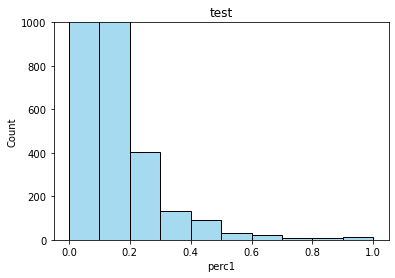

In [ ]:
makeHistogramForOverlap(test, column = 'perc1', title='test')

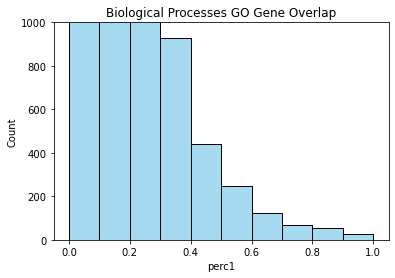

In [ ]:
makeHistogramForOverlap(bp_df, column = 'perc1', title = "Biological Processes GO Gene Overlap")

In [ ]:
def getNumberAbovePerc(overlap_df, perc):
    print(overlap_df.shape[0])
    
    print(overlap_df[overlap_df.perc1 >= perc].shape[0])
    
getNumberAbovePerc(bp_df, 0.5)
    
    

1986690
520


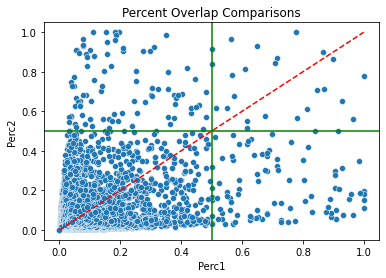

In [ ]:
makeScatter(mf_df)

In [ ]:
mf_df.sort_values(['perc1', 'perc2'], ascending=False)

,test_term,other_term,perc1,perc2
115,GO:1990404,GO:0003950,1.0,0.777778
348,GO:0070330,GO:0005506,1.0,0.196850
351,GO:0070330,GO:0020037,1.0,0.181159
351,GO:0016712,GO:0020037,1.0,0.152174
400,GO:0003925,GO:0005525,1.0,0.108808
...,...,...,...,...
329,GO:0019901,GO:0005179,0.0,0.000000
347,GO:0019901,GO:0005549,0.0,0.000000
349,GO:0019901,GO:0005506,0.0,0.000000
365,GO:0019901,GO:0004252,0.0,0.000000


In [ ]:
bp_df.sort_values(['perc1', 'perc2'], ascending=False)

,test_term,other_term,perc1,perc2
553,GO:0035521,GO:0035522,1.0,0.866667
942,GO:0035521,GO:0043966,1.0,0.541667
986,GO:0070316,GO:2000045,1.0,0.480769
1060,GO:0035521,GO:0006282,1.0,0.448276
1400,GO:0002377,GO:0006955,1.0,0.224299
...,...,...,...,...
1293,GO:0008284,GO:0007608,0.0,0.000000
1305,GO:0008284,GO:0007030,0.0,0.000000
1345,GO:0008284,GO:0016192,0.0,0.000000
1369,GO:0008284,GO:0007601,0.0,0.000000


In [ ]:
bp_overlap = bp_df[bp_df.perc1 >=0.5]

In [ ]:
mf_overlap = mf_df[mf_df.perc1 >=0.5]

NameError: name 'mf_df' is not defined